In [1]:
#import all necessary packages
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import keras_nlp
import keras
import os


2024-09-26 17:47:27.785126: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 17:47:27.785184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 17:47:27.787076: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BASE_PATH ="/kaggle/input/" 


os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="False"

## 1.Exploratory Data Analysis

## 1.1 Read the Data

In [3]:
path = "learning-agency-lab-automated-essay-scoring-2/"
df_train = pd.read_csv(f"{BASE_PATH}{path}train.csv")
print(f"We have about {df_train.shape[0]:,} essays")
df_train.head()

We have about 17,307 essays


,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


## 1.2 Devide the data 

In [4]:
class CFG:
    seed = 42  # Random seed
    preset = "deberta_v3_base_en" # Name of pretrained models
    sequence_length = 768  # Input sequence length
    epochs = 50 # Training epochs
    batch_size =8  # Batch size
    scheduler = 'cosine'  # Learning rate scheduler
    patience=5

In [5]:
#create our test set
train_df, valid_df = train_test_split(df_train, test_size=0.2, stratify=df_train["score"],random_state=CFG.seed)

## 1.3 Explore the data

What's the score distribution across the essays?

<Axes: xlabel='score', ylabel='count'>

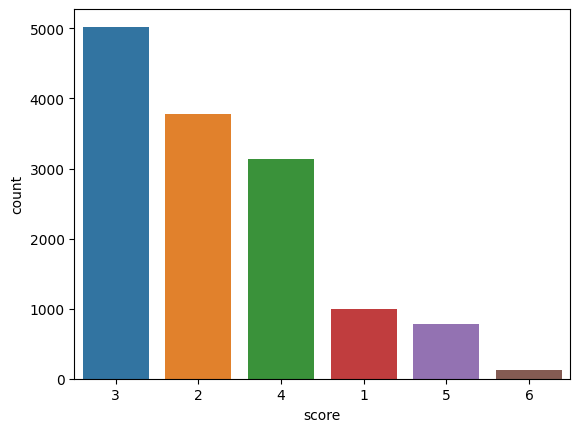

In [6]:
#visualize the score distribution across the essays
sns.countplot(data=train_df,
            x="score",
            order=train_df["score"].value_counts().index)

Is there a link between score and essay length or number of words?

<Axes: xlabel='score', ylabel='essay_length'>

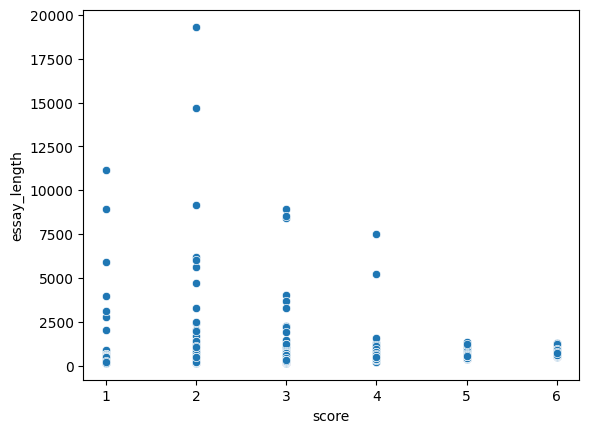

In [7]:
#compute the number of words per essays
train_df["essay_length"] = train_df["full_text"].apply(lambda x:len(x.split(" ")))

#plot the scatter plot

sns.scatterplot(data=train_df,x="score",y="essay_length")

In [8]:
print(f"The Pearson correlation is {np.corrcoef(train_df['essay_length'],train_df['score'])}")

The Pearson correlation is [[1.        0.2714245]
 [0.2714245 1.       ]]


There seems to be **no**  relationship between the length of the essay and the score the student gets. </br> This can also be seen with the low correlation pearson correlation value we obtain.

What's the distribution of tokens ?

In [ ]:
#load the tokenizer
tokenizer = keras_nlp.models.DebertaV3Tokenizer.from_preset(CFG.preset)


In [ ]:
#compute token length of each essay across the dataset
train_df["number_of_tokens"] = train_df["full_text"].apply(lambda x:tokenizer(x).shape[0])

#define a figure object of custom dimensions
plt.figure(figsize=(8,8),dpi=200)

#plot the histogram
sns.displot(data=train_df,x="number_of_tokens",kind="hist",kde=True)

In [ ]:
train_df["number_of_tokens"].describe()

# 2.Prepare the data

## Define some useful functions

In [9]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, # Name of the model
    sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter
)

def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text 

Attaching 'tokenizer.json' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...


In [10]:
def build_dataset(texts, labels=None, batch_size=CFG.batch_size,
                  cache=True, drop_remainder=True,
                  shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, labels)  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function
    opt = tf.data.Options()  # Create dataset options
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds

In [11]:
def to_ordinal(y, num_classes=None, dtype="float32"):
    """Converts a class vector (integers) to an ordinal regression matrix.

    This utility encodes class vector to ordinal regression/classification
    matrix where each sample is indicated by a row and rank of that sample is
    indicated by number of ones in that row.

    Args:
        y: Array-like with class values to be converted into a matrix
            (integers from 0 to `num_classes - 1`).
        num_classes: Total number of classes. If `None`, this would be inferred
            as `max(y) + 1`.
        dtype: The data type expected by the input. Default: `'float32'`.

    Returns:
        An ordinal regression matrix representation of the input as a NumPy
        array. The class axis is placed last.
    """
    y = np.array(y, dtype="int")
    input_shape = y.shape

    # Shrink the last dimension if the shape is (..., 1).
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    y = y.reshape(-1)
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    range_values = np.arange(num_classes - 1)
    range_values = np.tile(np.expand_dims(range_values, 0), [n, 1])
    ordinal = np.zeros((n, num_classes - 1), dtype=dtype)
    ordinal[range_values < np.expand_dims(y, -1)] = 1
    output_shape = input_shape + (num_classes - 1,)
    ordinal = np.reshape(ordinal, output_shape)
    return ordinal

In [12]:
# Train Data
train_df["label"] = to_ordinal(train_df.score.values).tolist()
valid_df["label"] = to_ordinal(valid_df.score.values).tolist()

train_texts = train_df.full_text.tolist()  # Extract training texts
train_labels = np.array(train_df.label.tolist())  # Extract training labels

# Build training dataset
train_ds = build_dataset(
    train_texts, train_labels, batch_size=CFG.batch_size, shuffle=True
)

# Valid Data
valid_texts = valid_df.full_text.tolist()  # Extract validation texts
valid_labels = np.array(valid_df.label.tolist())  # Extract validation labels

# Build validation dataset
valid_ds = build_dataset(
    valid_texts, valid_labels, batch_size=CFG.batch_size, shuffle=False
)

# 5. Training 

# Use the helper functions and classes provided in the starter Guide

In [13]:
import math
import matplotlib.pyplot as plt


def get_lr_callback(batch_size=CFG.batch_size, mode='cos', epochs=CFG.epochs, plot=False):
    lr_start, lr_max, lr_min = 0.6e-5, 0.3e-5 * batch_size, 0.3e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()


    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

lr_cb = get_lr_callback(CFG.batch_size, plot=False)

ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.weights.h5",
    monitor="val_weighted_kappa",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
)

#buuild the early stopping call back
early_callback = keras.callbacks.EarlyStopping(
    monitor='val_weighted_kappa',
    min_delta=0,
    patience=CFG.patience,
    verbose=1,
    mode='max',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

In [14]:
class WeightedKappa(keras.metrics.Metric):
    def __init__(self, num_classes=6, epsilon=1e-6):
        super().__init__(name="weighted_kappa")
        self.num_classes = num_classes
        self.epsilon = epsilon

        label_vec = keras.ops.arange(num_classes, dtype=keras.backend.floatx())
        self.row_label_vec = keras.ops.reshape(label_vec, [1, num_classes])
        self.col_label_vec = keras.ops.reshape(label_vec, [num_classes, 1])
        col_mat = keras.ops.tile(self.col_label_vec, [1, num_classes])
        row_mat = keras.ops.tile(self.row_label_vec, [num_classes, 1])
        self.weight_mat = (col_mat - row_mat) ** 2

        self.numerator = self.add_weight(name="numerator", initializer="zeros")
        self.denominator = self.add_weight(name="denominator", initializer="zeros")
        self.o_sum = self.add_weight(name = 'o_sum', initializer = 'zeros')
        self.e_sum = self.add_weight(name = 'e_sum', initializer = 'zeros')

    def update_state(self, y_true, y_pred, **args):
        # revert ordinal regression labels to classification labels
        p = keras.ops.sum(y_true, axis=-1) - 1
        p = keras.ops.cast(p,dtype="int8")
        y_true = keras.ops.one_hot(p, 6, dtype="int8")
        y_pred = keras.ops.one_hot(
            keras.ops.sum(keras.ops.cast(y_pred > 0.5, dtype="int8"), axis=-1) - 1, 6
        )
        # weighted kappa calculation
        y_true = keras.ops.cast(y_true, dtype=self.col_label_vec.dtype)
        y_pred = keras.ops.cast(y_pred, dtype=self.weight_mat.dtype)
        batch_size = keras.ops.shape(y_true)[0]

        cat_labels = keras.ops.matmul(y_true, self.col_label_vec)
        cat_label_mat = keras.ops.tile(cat_labels, [1, self.num_classes])
        row_label_mat = keras.ops.tile(self.row_label_vec, [batch_size, 1])

        weight = (cat_label_mat - row_label_mat) ** 2

        self.numerator.assign_add(keras.ops.sum(weight * y_pred))
        label_dist = keras.ops.sum(y_true, axis=0, keepdims=True)
        pred_dist = keras.ops.sum(y_pred, axis=0, keepdims=True)
        w_pred_dist = keras.ops.matmul(
            self.weight_mat, keras.ops.transpose(pred_dist, [1, 0])
        )
        self.denominator.assign_add(
            keras.ops.sum(keras.ops.matmul(label_dist, w_pred_dist))
        )
        
        self.o_sum.assign_add(keras.ops.sum(y_pred))
        self.e_sum.assign_add(keras.ops.sum(
            keras.ops.matmul(keras.ops.transpose(label_dist, [1, 0]), pred_dist)
        ))

    def result(self):
        return 1.0 - (
            keras.ops.divide_no_nan(self.numerator, self.denominator)
            * keras.ops.divide_no_nan(self.e_sum, self.o_sum)
        )

    def reset_state(self):
        self.numerator.assign(0)
        self.denominator.assign(0)
        self.o_sum.assign(0)
        self.e_sum.assign(0)
  


# Build and fit the Model

In [ ]:

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():
    # Create a DebertaV3Classifier model
    classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
        CFG.preset, preprocessor=None, num_classes=6
    )
    inputs = classifier.input
    logits = classifier(inputs)

    # Compute final output
    outputs = keras.layers.Activation("sigmoid")(logits)


    # Build Model
    model = keras.Model(inputs, outputs)

    # Compile the model with optimizer, loss, and metrics
    model.compile(
        optimizer=keras.optimizers.Adam(5e-6),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            WeightedKappa()
        ],
    )
    history = model.fit(
        train_ds,
        epochs=CFG.epochs,
        validation_data=valid_ds,
        callbacks=[lr_cb, ckpt_cb,early_callback]
    )


Attaching 'config.json' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...


Number of devices: 2


Attaching 'config.json' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/deberta_v3/keras/deberta_v3_base_en/2' to your Kaggle notebook...


Epoch 1/50
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 2949s 2s/step - loss: 0.5448 - weighted_kappa: 0.8743 - val_loss: 0.2021 - val_weighted_kappa: 0.6564 - learning_rate: 6.0000e-06
Epoch 2/50
1507/1730 ━━━━━━━━━━━━━━━━━━━━ 5:26 1s/step - loss: 0.3396 - weighted_kappa: 1.3583

In [ ]:
model.summary()

# 6 Generate the submission

In [ ]:
#recreate the mpodel and load the best weights
# Create a DebertaV3Classifier model
classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
    CFG.preset, preprocessor=None, num_classes=6
)
inputs = classifier.input
logits = classifier(inputs)

# Compute final output
outputs = keras.layers.Activation("sigmoid")(logits)


# Build Model
model = keras.Model(inputs, outputs)

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=keras.optimizers.Adam(5e-6),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        WeightedKappa()
    ],
)

In [ ]:
# # Test Data
test_df = pd.read_csv(f"{BASE_PATH}{path}test.csv")
test_texts = test_df.full_text.fillna("").tolist()  # Extract training texts

# Build training dataset
test_ds = build_dataset(
    test_texts,
    labels=None,
    batch_size=min(CFG.batch_size, len(test_df)),
    shuffle=False,
    drop_remainder=False,  # include all samples
)

# Do inference
# Load best checkpoint
model.load_weights("best_model.weights.h5")
test_preds = model.predict(test_ds, verbose=1)

# Convert probabilities to class labels
test_preds = np.sum((test_preds>0.5).astype(int), axis=-1).clip(1, 6)

# Create a DataFrame to store the submission
sub_df = test_df[["essay_id"]].copy()

# Add the formatted predictions to the submission DataFrame
sub_df["score"] = test_preds

# Save Submission
sub_df.to_csv('submission.csv',index=False)

# Display the first 2 rows of the submission DataFrame
sub_df.head()